## Direct Shooting 法を用いた最適化

### 最適化の概要
Direct Shooting 法を用いた最適化の例として，時間に対する **原料流量** \( u(t) \) の変化スケジュールを決定する。
制御変数を直接最適化し、状態方程式を数値積分することで最適軌道を求める

### 状態方程式（動的システムの記述）
化学反応器の動作を表す非線形微分方程式は以下の通り。

$$
\frac{dC_A}{dt} = \frac{F_{in}}{V} (C_{A,in} - C_A) - k C_A
$$

ここで：
- $$C_A$$ : 反応器内の物質 A の濃度
- $$F_{in}$$ : 原料の流量（最適化すべき制御変数）
- $$V$$ : 反応器の体積（定数）
- $$C_{A,in}$$ : 供給流の A の濃度（定数）
- $$k$$ : 反応速度定数（定数）

### 最適化の目的
時間 $$T$$ の範囲内で **反応器内の濃度を所望の値に近づける** ような流量スケジュール $$u(t)$$ を求める。そのために、コスト関数として以下の形で定義する。

$$
J = \sum_{t=0}^{T} (C_A - C_{A,target})^2 + \lambda u(t)^2
$$

ここで、$$\lambda$$ は制御入力のペナルティを調整する重みを表す。



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# 反応器のパラメータ
V = 1.0      # 体積
k = 0.5      # 反応速度定数
C_A_in = 1.0 # 供給流の濃度
C_A_target = 0.5  # 目標濃度

T_final = 10  # 最適化時間範囲
N = 10  # 制御入力の分割数（F_inをN個の区間で最適化）

# 反応器の状態方程式
def reactor_dynamics(t, C_A, F_in):
    return (F_in / V) * (C_A_in - C_A) - k * C_A

# シミュレーション関数
def simulate(F_in_schedule):
    time_grid = np.linspace(0, T_final, N+1)
    C_A_0 = [0.1]  # 初期濃度
    F_interp = lambda t: np.interp(t, time_grid, F_in_schedule)
    sol = solve_ivp(lambda t, C: reactor_dynamics(t, C, F_interp(t)), [0, T_final], C_A_0, t_eval=time_grid)
    return sol.t, sol.y[0]

# 目的関数 (出口濃度の偏差＋エネルギーコスト)
def objective(F_in_schedule):
    _, C_A_values = simulate(F_in_schedule)
    return np.sum((C_A_values - C_A_target)**2) + 0.01 * np.sum(F_in_schedule**2)

In [2]:
# 最適化の初期値
F_init = np.linspace(0.5, 1.0, N+1)  # 初期の流量スケジュール

# 最適化実行
bounds = [(0.1, 2.0)] * (N+1)  # 制御変数の範囲
result = minimize(objective, F_init, bounds=bounds, method='L-BFGS-B')

# 最適スケジュールの取得
F_opt = result.x

# シミュレーションと可視化
time_opt, C_A_opt = simulate(F_opt)

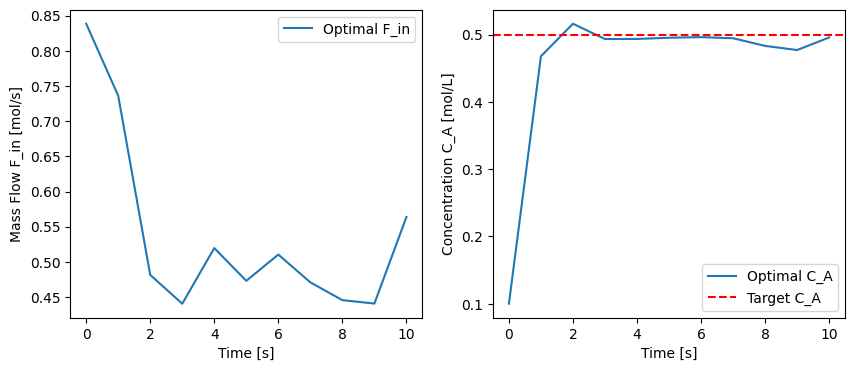

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_opt, F_opt, label="Optimal F_in")
plt.xlabel("Time [s]")
plt.ylabel("Mass Flow F_in [mol/s]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(time_opt, C_A_opt, label="Optimal C_A")
plt.axhline(C_A_target, linestyle="--", color="red", label="Target C_A")
plt.xlabel("Time [s]")
plt.ylabel("Concentration C_A [mol/L]")
plt.legend()

plt.show()